In [116]:
"""
@ Author:         21140684-李甜（小组成员：姜楠(21140678)、王勃栋(21140701)、李甜(21140684)）
@ Create Date:    2021-11-01
@ Requirements:
1, Implmenting the decision tree using numpy and pandas without using sk-learn.
2, Implementation needs both classification with gini/entropy and regression with rss is optional.
3, You are required to test with a sample dataset and provide evaluation with confusion matrix.
4, Compare your implementation with Sk-learn Decision tree classifier.
"""
import numpy as np
import pandas as pd
import math
#定义树
class TreeNode:
    def __init__(self, data,output):
        self.data = data
        self.children = {}
        self.output = output
        self.index = -1
        
    def add_child(self,feature_value,obj):
        self.children[feature_value] = obj

In [191]:
#决策树实现
class DecisionTreeClassifierImpl:
    def __init__(self):
        self.__root = None

    def __count_unique(self,Y):
        d = {}
        for i in Y:
            if i not in d:
                d[i]=1
            else:
                d[i]+=1
        return d

    #信息熵
    def __entropy(self,Y):
        freq_map = self.__count_unique(Y)
        entropy_ = 0
        total = len(Y)
        for i in freq_map:
            p = freq_map[i]/total
            entropy_ += (-p)*math.log2(p)
        return entropy_
    
    def __gain_ratio(self,X,Y,selected_feature):
        info_orig = self.__entropy(Y) #
        info_f = 0  # 
        split_info = 0
        values = set(X[:,selected_feature])
        df = pd.DataFrame(X)
        df[df.shape[1]] = Y
        initial_size = df.shape[0] 
        for i in values:
            df1 = df[df[selected_feature] == i]
            current_size = df1.shape[0]
            info_f += (current_size/initial_size)*self.__entropy(df1[df1.shape[1]-1])
            split_info += (-current_size/initial_size)*math.log2(current_size/initial_size)
        if split_info == 0 :
            return math.inf

        info_gain = info_orig - info_f
        gain_ratio = info_gain / split_info
        return gain_ratio

    def __gini_index(self,Y):
        # 返回gini index
        freq_map = self.__count_unique(Y)
        gini_index_ = 1
        total = len(Y)
        for i in freq_map:
            p = freq_map[i]/total
            gini_index_ -= p**2
        return gini_index_

    def __gini_gain(self,X,Y,selected_feature):
        gini_orig = self.__gini_index(Y) 
        gini_split_f = 0 
        values = set(X[:,selected_feature])
        df = pd.DataFrame(X)
        df[df.shape[1]] = Y
        initial_size = df.shape[0] 
        for i in values:
            df1 = df[df[selected_feature] == i]
            current_size = df1.shape[0]
            gini_split_f += (current_size/initial_size)*self.__gini_index(df1[df1.shape[1]-1])

        gini_gain_ = gini_orig - gini_split_f
        return gini_gain_
    #决策树实现
    def __decision_tree(self,X,Y,features,level,metric,classes):
        
        if len(set(Y)) == 1:
            print("Level",level)
            output = None
            for i in classes:
                if i in Y:
                    output = i
                    print("Count of",i,"=",len(Y))
                else :
                    print("Count of",i,"=",0)
            if metric == "gain_ratio":
                print("Current Entropy is =  0.0")
            elif metric == "gini_index":
                print("Current Gini Index is =  0.0")

            print("Reached leaf Node")
            print()
            return TreeNode(None,output)

       
        if len(features) == 0:
            print("Level",level)
            freq_map = self.__count_unique(Y)
            output = None
            max_count = -math.inf
            for i in classes:
                if i not in freq_map:
                    print("Count of",i,"=",0)
                else :
                    if freq_map[i] > max_count :
                        output = i
                        max_count = freq_map[i]
                    print("Count of",i,"=",freq_map[i])

            if metric == "gain_ratio":
                print("Current Entropy  is =",self.__entropy(Y))
            elif metric == "gini_index":
                print("Current Gini Index is =",self.__gini_index(Y))            

            print("Reached leaf Node")
            print()
            return TreeNode(None,output)

        
        max_gain = -math.inf
        final_feature = None
        for f in features :
            if metric == "gain_ratio":
                current_gain = self.__gain_ratio(X,Y,f)
            elif metric =="gini_index":
                current_gain = self.__gini_gain(X,Y,f)

            if current_gain > max_gain:
                max_gain = current_gain
                final_feature = f

        print("Level",level)
        freq_map = self.__count_unique(Y)
        output = None
        max_count = -math.inf

        for i in classes:
            if i not in freq_map:
                print("Count of",i,"=",0)
            else :
                if freq_map[i] > max_count :
                    output = i
                    max_count = freq_map[i]
                print("Count of",i,"=",freq_map[i])

        if metric == "gain_ratio" :        
            print("Current Entropy is =",self.__entropy(Y))
            print("Splitting on feature  X[",final_feature,"] with gain ratio ",max_gain,sep="")
            print()
        elif metric == "gini_index":
            print("Current Gini Index is =",self.__gini_index(Y))
            print("Splitting on feature  X[",final_feature,"] with gini gain ",max_gain,sep="")
            print()
            
        unique_values = set(X[:,final_feature]) 
        df = pd.DataFrame(X)
        df[df.shape[1]] = Y

        current_node = TreeNode(final_feature,output)

        index  = features.index(final_feature)
        features.remove(final_feature)
        for i in unique_values:
            df1 = df[df[final_feature] == i]
            node = self.__decision_tree(df1.iloc[:,0:df1.shape[1]-1].values,df1.iloc[:,df1.shape[1]-1].values,features,level+1,metric,classes)
            current_node.add_child(i,node)

        features.insert(index,final_feature)

        return current_node
    
    def fit(self,X,Y,metric="gain_ratio"):
        # 训练，默认信息熵方式
        features = [i for i in range(len(X[0]))]
        classes = set(Y)
        level = 0
        if metric != "gain_ratio" :
            if metric != "gini_index":
                metric="gain_ratio"  
        self.__root = self.__decision_tree(X,Y,features,level,metric,classes)
        
    def __predict_for(self,data,node):
        
        if len(node.children) == 0 :
            return node.output

        val = data[node.data]     
        if val not in node.children :
            return node.output
        
        return self.__predict_for(data,node.children[val])

    def predict(self,X):
        # 预测
        Y = np.array([0 for i in range(len(X))])
        for i in range(len(X)):
            Y[i] = self.__predict_for(X[i],self.__root)
        return Y
    
    #展示树dot代码
    def export_tree(self):
        
        import pydotplus
        from collections import deque
        
        dot_data = '''digraph Tree {
node [shape=box] ;'''
        
        queue = deque()
        
        r = self.__root
        queue.append(r)
        count = 0
        if r.index == -1:
            r.index = count
        
        dot_data = dot_data + "\n{} [label=\"Feature to split upon : X[{}]\\nOutput at this node : {}\" ];".format(count,r.data,r.output) 
        
        # Doing LEVEL ORDER traversal in the tree (using a queue)
        while len(queue) != 0 :
            node = queue.popleft()
            for i in node.children:
                count+=1
                if(node.children[i].index==-1):
                    node.children[i].index = count
                
                # Creating child node
                dot_data = dot_data + "\n{} [label=\"Feature to split upon : X[{}]\\nOutput at this node : {}\" ];".format(node.children[i].index,node.children[i].data,node.children[i].output) 
                # Connecting parent node with child
                dot_data = dot_data + "\n{} -> {} [ headlabel=\"Feature value = {}\"]; ".format(node.index,node.children[i].index,i)
                # Adding child node to queue
                queue.append(node.children[i])
        
        dot_data = dot_data + "\n}"
        
        return dot_data
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("显示百分比：")
        np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
        print(cm)
    else:
        print('显示具体数字：')
        print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(len(classes) - 0.5, -0.5)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [192]:
#数据集准备
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris


%matplotlib inline

iris = load_iris()
plt.rcParams['figure.figsize'] = (10, 8)

#some more code
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2)




In [193]:
# 2 input OR GATE
clf1 = DecisionTreeClassifierImpl()


clf1.fit(X_train,y_train)
Y_pred = clf1.predict(X_test)
print("Predictions :",Y_pred)


dotdata = clf1.export_tree()


Level 0
Count of 0 = 45
Count of 1 = 34
Count of 2 = 41
Current Entropy is = 1.5755009445527823
Splitting on feature  X[3] with gain ratio 0.360507648127355

Level 1
Count of 0 = 25
Count of 1 = 0
Count of 2 = 0
Current Entropy is =  0.0
Reached leaf Node

Level 1
Count of 0 = 0
Count of 1 = 1
Count of 2 = 10
Current Entropy is = 0.4394969869215134
Splitting on feature  X[1] with gain ratio 0.1010370120897153

Level 2
Count of 0 = 0
Count of 1 = 0
Count of 2 = 1
Current Entropy is =  0.0
Reached leaf Node

Level 2
Count of 0 = 0
Count of 1 = 0
Count of 2 = 1
Current Entropy is =  0.0
Reached leaf Node

Level 2
Count of 0 = 0
Count of 1 = 0
Count of 2 = 1
Current Entropy is =  0.0
Reached leaf Node

Level 2
Count of 0 = 0
Count of 1 = 0
Count of 2 = 4
Current Entropy is =  0.0
Reached leaf Node

Level 2
Count of 0 = 0
Count of 1 = 0
Count of 2 = 1
Current Entropy is =  0.0
Reached leaf Node

Level 2
Count of 0 = 0
Count of 1 = 0
Count of 2 = 1
Current Entropy is =  0.0
Reached leaf Node

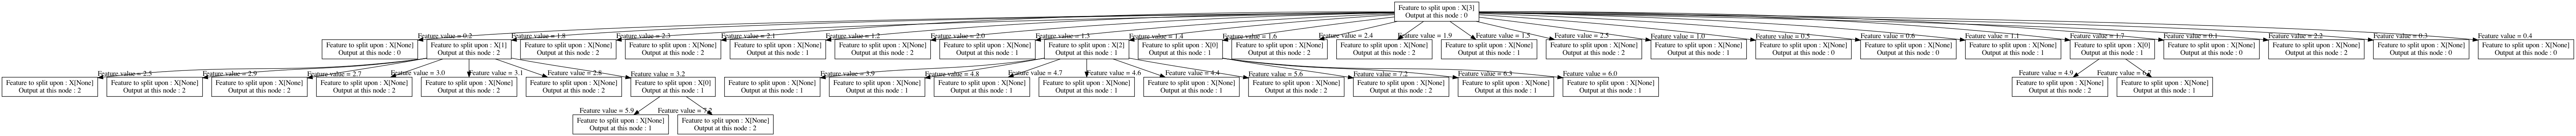

In [194]:
#展示决策树
import pydot
import graphviz
from IPython.display import Image
(graph,) = pydot.graph_from_dot_data(dotdata)

Image(graph.create_png())

显示具体数字：
[[ 5  0  0]
 [ 0 16  0]
 [ 0  2  7]]


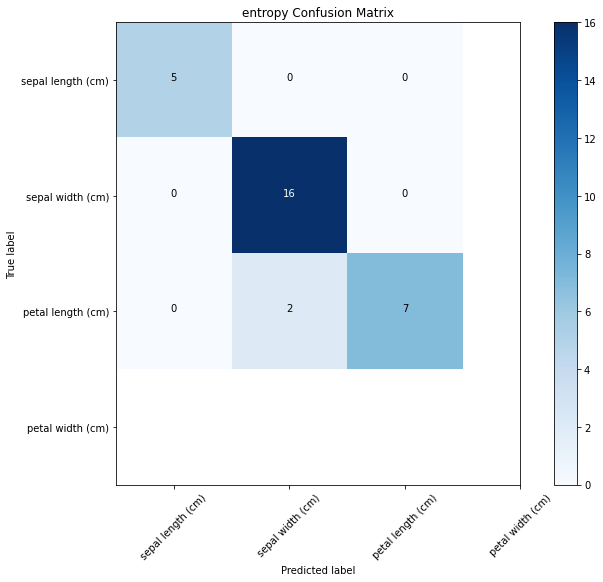

In [195]:
#  信息熵混淆矩阵
cm = confusion_matrix(y_test, Y_pred)
plot_confusion_matrix(cm, iris.feature_names,
                      title = 'entropy Confusion Matrix')

In [196]:

clf1.fit(X_train,y_train,"gini_index")
Y_pred = clf1.predict(X_test)
print("Predictions :",Y_pred)
dotdata = clf1.export_tree()

# plot_tree(clf1,  filled=True);


Level 0
Count of 0 = 45
Count of 1 = 34
Count of 2 = 41
Current Gini Index is = 0.6623611111111111
Splitting on feature  X[3] with gini gain 0.6117929292929293

Level 1
Count of 0 = 25
Count of 1 = 0
Count of 2 = 0
Current Gini Index is =  0.0
Reached leaf Node

Level 1
Count of 0 = 0
Count of 1 = 1
Count of 2 = 10
Current Gini Index is = 0.1652892561983472
Splitting on feature  X[0] with gini gain 0.07438016528925628

Level 2
Count of 0 = 0
Count of 1 = 1
Count of 2 = 1
Current Gini Index is = 0.5
Splitting on feature  X[1] with gini gain 0.5

Level 3
Count of 0 = 0
Count of 1 = 1
Count of 2 = 0
Current Gini Index is =  0.0
Reached leaf Node

Level 3
Count of 0 = 0
Count of 1 = 0
Count of 2 = 1
Current Gini Index is =  0.0
Reached leaf Node

Level 2
Count of 0 = 0
Count of 1 = 0
Count of 2 = 1
Current Gini Index is =  0.0
Reached leaf Node

Level 2
Count of 0 = 0
Count of 1 = 0
Count of 2 = 1
Current Gini Index is =  0.0
Reached leaf Node

Level 2
Count of 0 = 0
Count of 1 = 0
Count o

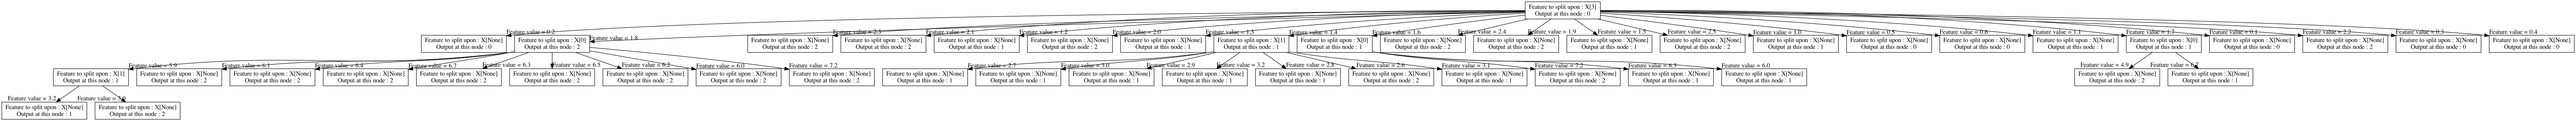

In [197]:
(graph,) = pydot.graph_from_dot_data(dotdata)

Image(graph.create_png())
# dotdata

显示具体数字：
[[ 5  0  0]
 [ 0 16  0]
 [ 0  2  7]]


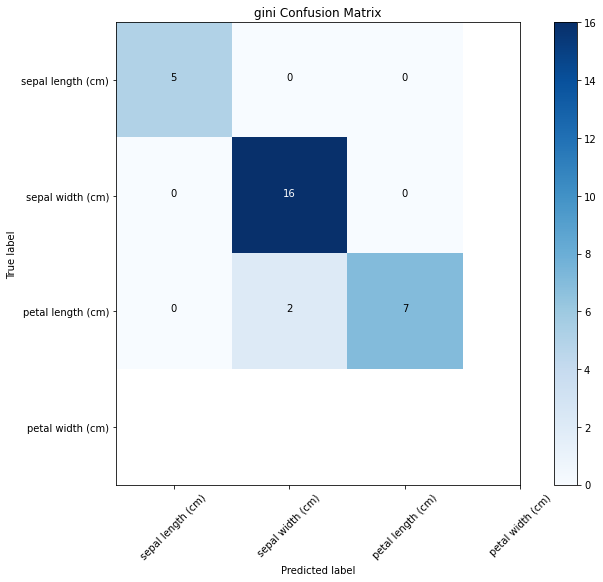

In [198]:
#  gini 混淆矩阵
cm = confusion_matrix(y_test, Y_pred)
plot_confusion_matrix(cm, iris.feature_names,
                      title = 'gini Confusion Matrix')

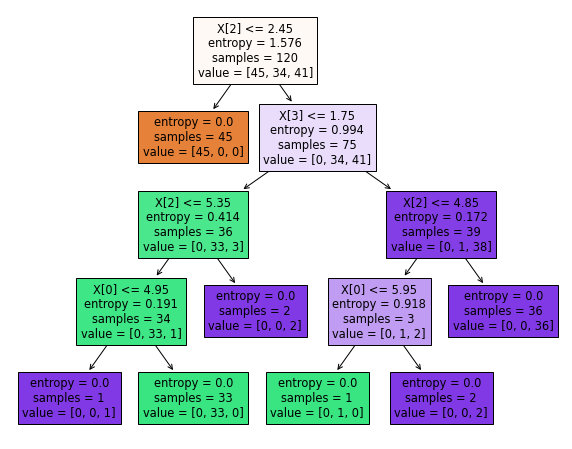

In [199]:
#sklearn 信息熵
dt = DecisionTreeClassifier(criterion='entropy', random_state=17)
dt.fit(X_train, y_train)
y_pre=dt.predict(X_test)
#displaying the tree
plot_tree(dt,  filled=True);
# plt.show()

显示具体数字：
[[ 5  0  0]
 [ 0 15  1]
 [ 0  2  7]]


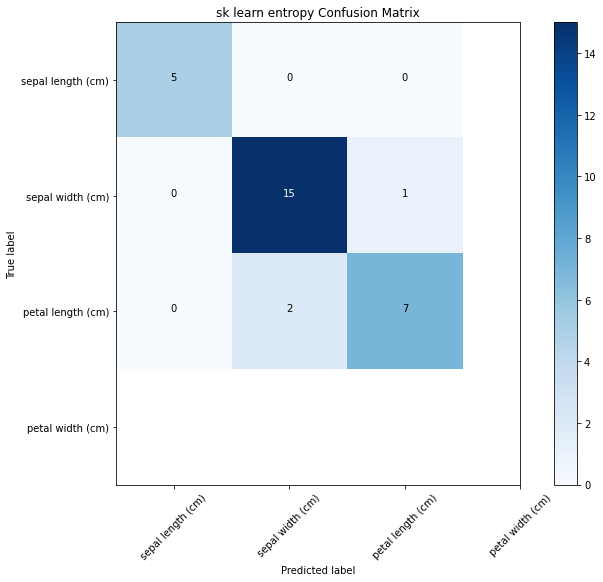

In [200]:
# sk learn 信息熵混淆矩阵
cm = confusion_matrix(y_test, y_pre)
plot_confusion_matrix(cm, iris.feature_names,
                      title = 'sk learn entropy Confusion Matrix')

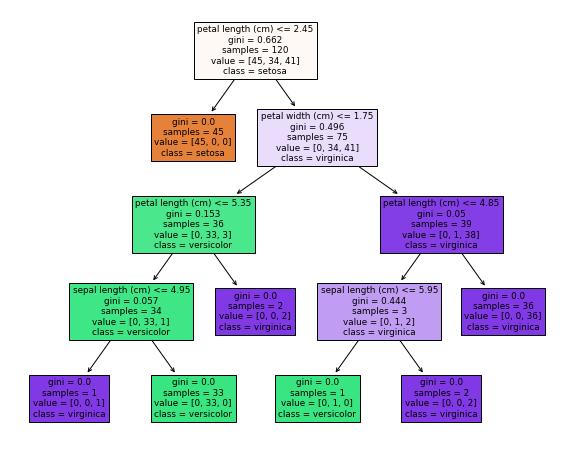

In [201]:
#sklearn gini
dt = DecisionTreeClassifier(criterion='gini', random_state=17)
dt.fit(X_train, y_train)

#displaying the tree
plot_tree(dt, feature_names=iris.feature_names, filled=True,
         class_names=iris.target_names);

显示具体数字：
[[ 5  0  0]
 [ 0 15  1]
 [ 0  2  7]]


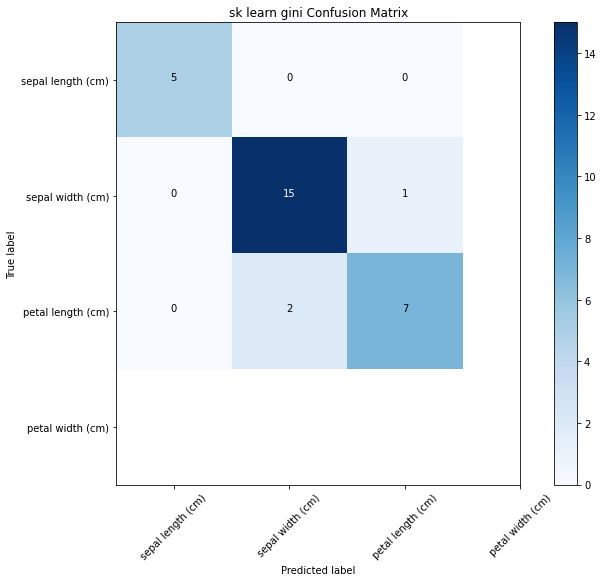

In [202]:
# sk learn gini混淆矩阵
cm = confusion_matrix(y_test, y_pre)
plot_confusion_matrix(cm, iris.feature_names,
                      title = 'sk learn gini Confusion Matrix')